In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_score, f1_score, precision_score, recall_score
from skimage.metrics import structural_similarity as ssim
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Lambda, GlobalAveragePooling2D, Lambda
from keras.src.legacy.preprocessing.image import ImageDataGenerator

import random
import re
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import gc

2025-05-01 21:19:16.505002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 21:19:16.574622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 21:19:16.627419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 21:19:17.697535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {gpus}")
else:
    print("Nenhuma GPU encontrada.")

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'  # Desativa XLA

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1746145192.667208    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145194.523202    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145194.523400    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
imgs_path = 'DATASET_dicom_fourier_spectrum'

model_path = "Results/Turnstile_CNN results (1%)/model_fold_0.keras"

TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1

EPOCHS = 200
BATCH_SIZE = 32
RANDOM_STATE = 53

HIGH_FREQ_THRESHOLD = 1

In [4]:
def get_next_filename(output_folder, base_name, type):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_index = 0
    
    while True:
        output_filename = f"{base_name}_{image_index}.{type}"
        output_path = os.path.join(output_folder, output_filename)
        
        if not os.path.exists(output_path):
            return output_filename
            
        image_index += 1

In [5]:
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0

In [6]:
def sort_files_numerically(file_paths):
    return sorted(file_paths, key=lambda x: extract_number(x))

In [7]:
def read_dataset(path, jpg, png):
    print(f'Reading dataset...\n')
    
    img_type = []
    images = []
    image_paths = []

    if jpg:
        img_type.append('*.jpg')
    if png:
        img_type.append('*.png')

    print(f'Reading images from: {path}')
    
    for img_type_pattern in img_type:
        img_paths = glob.glob(os.path.join(path, img_type_pattern))
        img_paths = sort_files_numerically(img_paths)
        
        for img_path in img_paths:
            img = cv2.imread(img_path, 0)
            images.append(img)
            image_paths.append(img_path)

    images = np.array(images)
    image_paths = np.array(image_paths)

    return images, image_paths

In [8]:
all_X, all_image_paths = read_dataset(path=imgs_path, jpg=True, png=True)

Reading dataset...

Reading images from: AES_decrypt_spectrum_metrics


In [9]:
def noise(image, threshold, add_noise, fshift):
    if add_noise:
        amplification_factor = 0.5
        rows, cols = image.shape
        crow, ccol = rows//2, cols//2

        corner = np.random.randint(0, 4)
        
        mask = np.zeros((rows, cols), dtype=bool)
        
        if corner == 0:    # Canto superior esquerdo
            mask[:crow - threshold, :ccol - threshold] = True
        elif corner == 1:  # Canto superior direito
            mask[:crow - threshold, ccol + threshold:] = True
        elif corner == 2:  # Canto inferior esquerdo
            mask[crow + threshold:, :ccol - threshold] = True
        else:              # Canto inferior direito
            mask[crow + threshold:, ccol + threshold:] = True

        fshift[mask] *= amplification_factor

    magnitude_spectrum_high = 20 * np.log(np.abs(fshift) + 1)

    return magnitude_spectrum_high

In [10]:
def process_and_save_chunks(chunk_size=50):
    half = len(all_X) // 2
    fshift_dir = "DATASET_dicom_fourier_shift"
    file_list = sorted(os.listdir(fshift_dir))
    temp_dir = "temp_processed"
    os.makedirs(temp_dir, exist_ok=True)

    for chunk_start in tqdm(range(0, len(all_X), chunk_size)):
        chunk_end = min(chunk_start + chunk_size, len(all_X))
        
        specs_chunk = []
        labels_chunk = []
        
        for i in range(chunk_start, chunk_end):
            img = all_X[i]
            filename = file_list[i]
            fshift = np.load(os.path.join(fshift_dir, filename))
            
            if i < half:
                processed = noise(img, 100 - HIGH_FREQ_THRESHOLD, add_noise=False, fshift=fshift)
                label = 0
            else:
                processed = noise(img, 100 - HIGH_FREQ_THRESHOLD, add_noise=True, fshift=fshift)
                label = 1
            
            specs_chunk.append(processed)
            labels_chunk.append(label)
        
        np.save(os.path.join(temp_dir, f"specs_chunk_{chunk_start}.npy"), np.array(specs_chunk))
        np.save(os.path.join(temp_dir, f"labels_chunk_{chunk_start}.npy"), np.array(labels_chunk))
        
        del specs_chunk, labels_chunk
        gc.collect()

In [ ]:
process_and_save_chunks(chunk_size=50)

In [ ]:
class LazyDataLoader:
    def __init__(self, temp_dir="temp_processed"):
        self.temp_dir = temp_dir
        self.spec_chunks = sorted(glob.glob(os.path.join(temp_dir, "specs_chunk_*.npy")), 
                               key=lambda x: int(re.findall(r'specs_chunk_(\d+).npy', x)[0]))
        self.label_chunks = sorted(glob.glob(os.path.join(temp_dir, "labels_chunk_*.npy")), 
                                key=lambda x: int(re.findall(r'labels_chunk_(\d+).npy', x)[0]))
        
    def get_total_samples(self):
        total = 0
        for spec_file in self.spec_chunks:
            total += np.load(spec_file).shape[0]
        return total

    def load_labels(self):
        all_labels = []
        for label_file in self.label_chunks:
            all_labels.extend(np.load(label_file))
        return np.array(all_labels)

In [ ]:
lazy_loader = LazyDataLoader()
all_indices = np.arange(lazy_loader.get_total_samples())
all_labels = lazy_loader.load_labels()

In [11]:
print("Quantidade das imagens:", all_indices.shape)
print("Exemplo dos labels (False = original, True = com ruído):", all_labels)

Quantidade das imagens: (164, 224, 224)
Exemplo dos labels (False = original, True = com ruído): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
X_train, X_test, y_train, y_test, = train_test_split(
        all_specs, all_labels,
        test_size=TEST_SIZE, 
        stratify=all_labels,
#       random_state=RANDOM_STATE
    )

In [13]:
def plot_specs(specs, title):
    total_images = len(specs)
    imgs_per_figure = 100
    cols = 5
    rows = (imgs_per_figure + cols - 1) // cols

    for start in range(0, total_images, imgs_per_figure):
        plt.figure(figsize=(cols * 3, rows * 3))
        end = min(start + imgs_per_figure, total_images)
        
        for i in range(start, end):
            plt.subplot(rows, cols, i - start + 1)
            plt.imshow(specs[i], cmap='gray')
            plt.title(f"{title} - freq spec: img {i+1}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

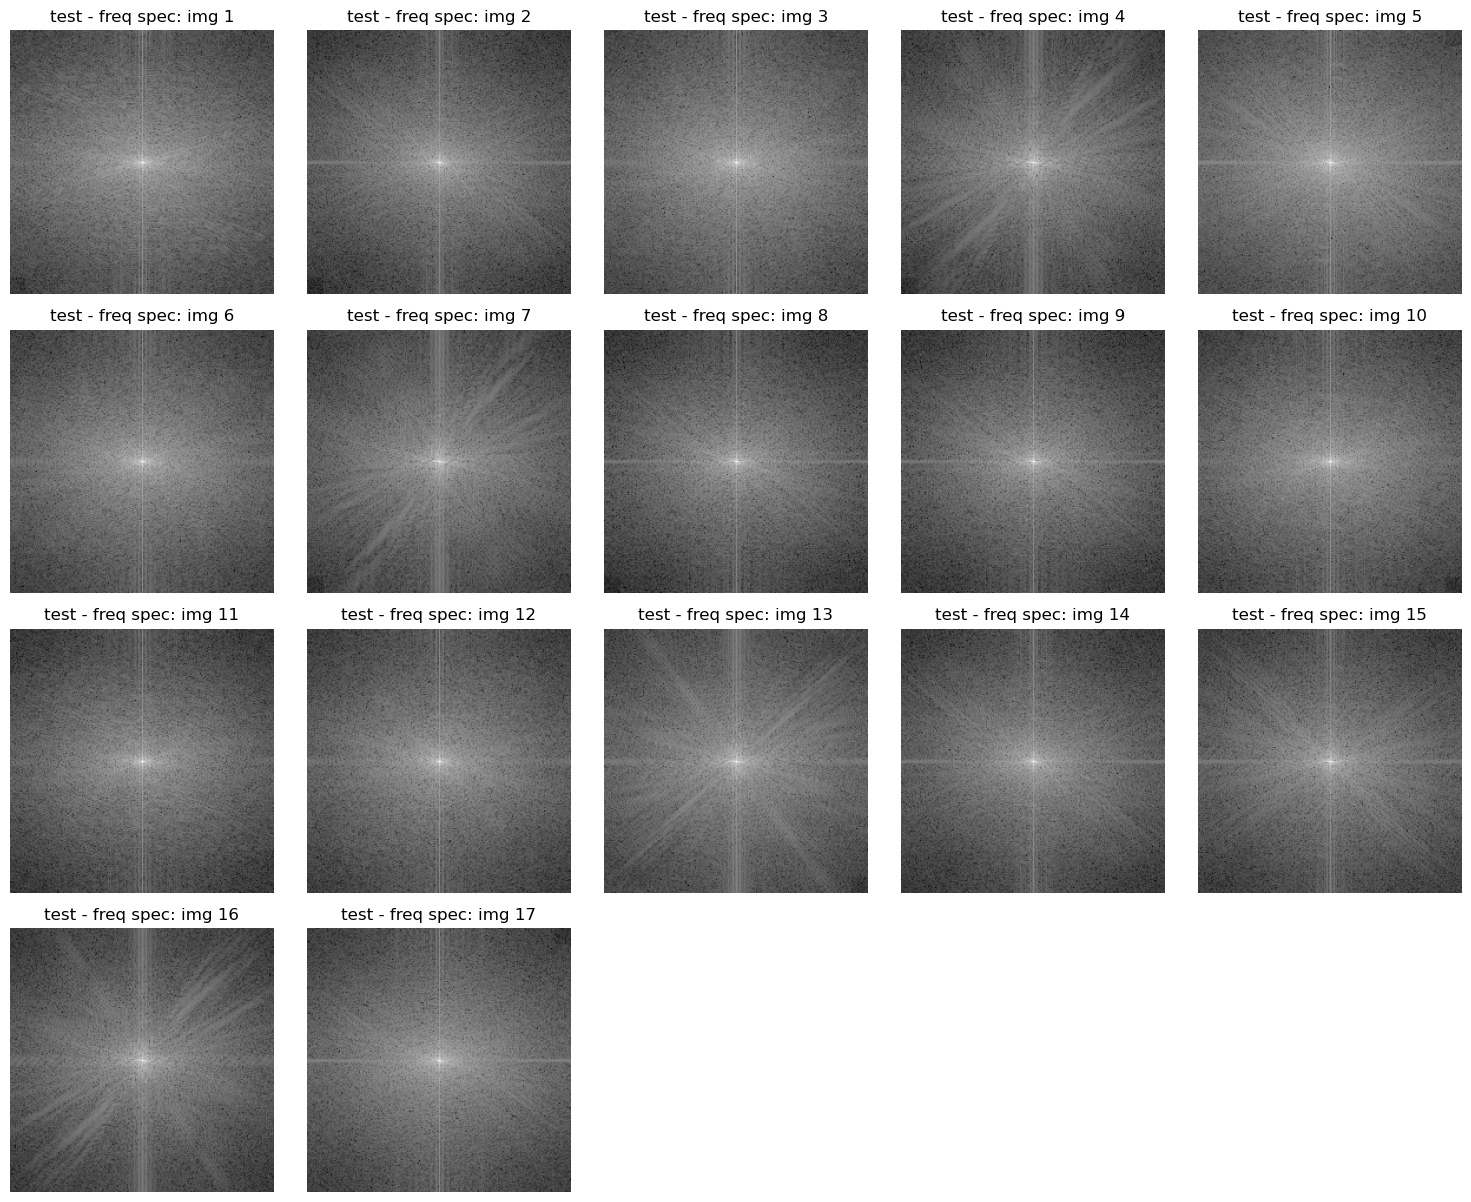

In [14]:
# Plotar todos os espectros de teste
plot_specs(X_test, title="test")

In [15]:
#pausa de teste

In [16]:
# Função que replica a operação da camada Lambda
def expand_channels(x):
    return tf.stack([x[..., 0]] * 3, axis=-1)

# Carregue o modelo com ambos os objetos personalizados
model = load_model(
    model_path,
    custom_objects={'tf': tf, '<lambda>': expand_channels},
    safe_mode=False
)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Lambda):
        layer.function = expand_channels

for layer in model.layers:
    layer.trainable = False

I0000 00:00:1746145203.037283    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145203.037395    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145203.037462    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145204.042627    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746145204.042760    4665 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ lambda[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ lambda[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r

 Total params: 71,624,854 (273.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,910,364 (91.21 MB)

 Optimizer params: 47,714,490 (182.02 MB)

In [18]:
#pausa de teste

In [19]:
from matplotlib import cm

In [20]:
def generate_heatmap(model, sample_image):
    sample_image_exp = np.expand_dims(sample_image, axis=0)

    # Obtem as ativações da última camada convolucional
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)
    activations = intermediate_model.predict(sample_image_exp)
    activations = tf.convert_to_tensor(activations)

    predictions = model.predict(sample_image_exp)

    with tf.GradientTape() as tape:
        # Cria um modelo que nos dê a saída do modelo e as ativações da última camada convolucional
        iterate = Model([model.input], [model.output, model.get_layer('conv5_block3_3_conv').output])
        model_out, last_conv_layer = iterate(sample_image_exp)
        
        # Pegua a saída da classe predita
        class_out = model_out[:, np.argmax(model_out[0])]
        
        # Registra as operações a serem diferenciadas
        tape.watch(last_conv_layer)
        
        # Calcula os gradientes
        grads = tape.gradient(class_out, last_conv_layer)
        
        # Mensagem de depuração para verificar gradientes
#       print("Gradients calculated:", grads)

    # Verifica se os gradientes foram calculados corretamente
    if grads is None:
        raise ValueError('Gradients could not be computed. Check the model and layer names.')
    
    # Média dos gradientes sobre as dimensões espaciais
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Mensagem de depuração para verificar pooled_grads
#   print("Pooled gradients:", pooled_grads)
    
    # Regularização dos gradientes
    pooled_grads = tf.where(pooled_grads == 0, tf.ones_like(pooled_grads) * 1e-10, pooled_grads)
    
    # Multiplique as ativações pelos gradientes ponderados e tire a média
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer[0]), axis=-1)
    
    # Mensagem de depuração para verificar heatmap inicial
#   print("Initial heatmap:", heatmap)

    # Normaliza o heatmap se possível
    min_value = np.min(heatmap)
    
    # Normaliza o heatmap se possível
    max_value = np.max(heatmap)

    # Aplica ReLU para garantir que os valores sejam não-negativos
    heatmap = (heatmap - min_value) / (max_value - min_value)
    heatmap = np.asarray(heatmap)
    heatmap = (heatmap - 1) * (-1)

    # Mensagem de depuração para verificar heatmap normalizado
#   print("Normalized heatmap:", heatmap)
    
    # Redimensiona o heatmap para o tamanho da imagem de entrada
    heatmap_resized = cv2.resize(heatmap, (sample_image.shape[1], sample_image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Aplica um mapa de cores
    heatmap_colored = cm.jet(heatmap_resized)[:, :, :3]
    heatmap_colored = np.uint8(heatmap_colored * 255)
    
    # Cria um canal alfa a partir do heatmap redimensionado
    alpha_channel = np.uint8(heatmap_resized)
    heatmap_colored_with_alpha = np.dstack((heatmap_colored, alpha_channel))
    
    # Converte a imagem original para uint8 e RGBA
    sample_image_uint8 = np.uint8(255 * np.squeeze(sample_image))
    image_rgb = cv2.cvtColor(sample_image_uint8, cv2.COLOR_GRAY2RGB)
    image_rgba = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2RGBA)
    
    # Combina a imagem original com o heatmap
    alpha_factor = alpha_channel / 255.0
    for c in range(0, 3):
        image_rgba[..., c] = image_rgba[..., c] * (1 - alpha_factor) + heatmap_colored[..., c] * alpha_factor
    
    return image_rgba

In [21]:
# Gerar o mapa de calor
output_folder = 'AnyHeatmap'
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
type = 'png'

def heatmap_models(model, image_normalized, nome):
    base_name = 'heatmap_' + nome
    output_filename = get_next_filename(output_folder, base_name, type)
    output_path = os.path.join(output_folder, output_filename)
    
    heatmap_image = generate_heatmap(model, image_normalized)
    plt.figure(figsize=(10, 5))
    
# Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(image_normalized.squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
# Mapa de calor com predição
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_image)
    plt.title(f'ResNet50')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

In [ ]:
for idx in tqdm(range(int(len(X_test)/2)), desc="Gerando Mapas de Ativação"):
    # Pré-processamento
    image = X_test[idx].astype('float32')
    image = np.expand_dims(image, axis=-1)
    
    # Gerar heatmap
    try:
        heatmap_image = generate_heatmap(model, image)
        
        # Plotar e salvar
        plt.figure(figsize=(10, 5))
        
        # Imagem Original
        plt.subplot(1, 2, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Original - Img {idx}')
        plt.axis('off')
        
        # Mapa de Calor
        plt.subplot(1, 2, 2)
        plt.imshow(heatmap_image)
        plt.title(f'Heatmap - Classe: {y_test[idx]}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'heatmap_test_{idx}.png'))
        plt.close()
    
    except Exception as e:
        print(f"Erro na imagem {idx}: {str(e)}")

Gerando Mapas de Ativação:   0%|                                                                  | 0/8 [00:00<?, ?it/s]I0000 00:00:1746145220.041731    4728 service.cc:146] XLA service 0x7f5b18002130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746145220.041784    4728 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-01 21:20:20.511636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-01 21:20:22.094054: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


I0000 00:00:1746145231.417656    4728 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(
W0000 00:00:1746145234.889373    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.079074    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.080835    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.083139    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.260186    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.261471    4665 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746145235.262830    4

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Gerando Mapas de Ativação:  25%|██████████████▌                                           | 2/8 [00:46<02:03, 20.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Gerando Mapas de Ativação:  38%|█████████████████████▊                                    | 3/8 [00:52<01:08, 13.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Gerando Mapas de Ativação:  50%|█████████████████████████████                             | 4/8 [01:27<01:28, 22.14s/it]2025-05-01 21:51:11.164364: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_34968__.1671] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
# GC collect
tf.keras.backend.clear_session()
gc.collect()